# This has plots of the SSD, U held constant, and mean from the 2D histogram


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import stats
import pickle
# import tensorflow as tf

In [3]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2).astype(float)
k_plus = np.sqrt(k**2 +(m+m_U)**2).astype(float)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [22]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
initial_state_tensor = tf.convert_to_tensor(initial_state, dtype=tf.float32)
t_span = (0, 1100)
dt = 0.001
dt_tensor = tf.constant(dt, dtype=tf.float32)
k_e_tensor = tf.constant(k_e, dtype=tf.float32)
k_tensor = tf.constant(k, dtype=tf.float32)
epsilon = 0.01  #noise strength (0.01 has been well used)
epsilon_tensor = tf.constant(epsilon, dtype=tf.float32)

def euler_maruyama(y0, t_span, dt, epsilon):
    t0, t_final = t_span  # Unpack the tuple
    t0_tensor = tf.constant(t0, dtype=tf.float32)
    t_final_tensor = tf.constant(t_final, dtype=tf.float32)
    t = tf.linspace(t0_tensor, t_final_tensor, tf.cast((t_final_tensor - t0_tensor) / dt_tensor, tf.int32) + 1)
    
    # Convert numpy arrays to tensors
    W_tensor = tf.convert_to_tensor(W, dtype=tf.float32)
    L_tensor = tf.convert_to_tensor(L, dtype=tf.float32)
    y0_tensor = tf.convert_to_tensor(y0, dtype=tf.float32)
    
    # Initialize tensors
    s = tf.Variable(tf.zeros((4, len(t)), dtype=tf.float32))
    U = tf.Variable(tf.zeros(len(t), dtype=tf.float32))
 
    s[0, 0].assign(y0_tensor[0])
    s[1, 0].assign(y0_tensor[1])
    s[2, 0].assign(y0_tensor[2])
    s[3, 0].assign(y0_tensor[3])
    U[0].assign(y0_tensor[4])

    for i in range(len(t) - 1):
        # noise_forcing = tf.sqrt(dt) * (2 * tf.sqrt(2) / k_e) * tf.random.normal([1], 0, 1)
        noise_forcing = tf.sqrt(dt) * tf.random.normal([1], 0, 1)
        noise_forcing_vector = tf.concat([noise_forcing, [0, 0, 0]], 0)
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1].assign(s[:, i] + dt * (tf.linalg.matvec(W_tensor, s[:, i]) + U[i] * tf.linalg.matvec(L_tensor, s[:, i])) + tf.sqrt(epsilon) * noise_forcing_vector)
        U[i + 1].assign(U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i])))
    
    y = tf.concat([s, tf.expand_dims(U, axis=0)], axis=0)
    return t, y

In [24]:
t, y = euler_maruyama(initial_state_tensor, t_span, dt_tensor, epsilon_tensor)   # Solve the SDE

In [23]:
## The code below is used to generate the training data for the neural network

# Rest of the code remains the same
t, y = euler_maruyama(initial_state_tensor, t_span, dt_tensor, epsilon_tensor)   # Solve the SDE
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 

# Extract the desired values
U = y[4]  # Extract U values

# Find the index corresponding to time t=100
start_index = int(100 / dt) 

# Slice U and R arrays starting from the index of t=100
U = U[start_index:]
R = R[start_index:]

# Create a DataFrame with U and R
df = pd.DataFrame({'U': U.numpy(), 'R': R.numpy()})

# df.to_csv('./data/train_data_gpuacc.csv', index=False) #save the dataframe as a csv file

KeyboardInterrupt: 

In [11]:
def autocorrelation_fft(data):
    data = data - np.mean(data)  # Remove the mean
    n = len(data)
    
    # Compute the power spectral density (PSD)
    data_fft = np.fft.fft(data, n=2*n)  # Zero-padding for avoiding circular convolution
    psd = np.abs(data_fft)**2
    
    # Compute the inverse Fourier transform of the PSD
    autocorr = np.fft.ifft(psd)
    
    # Keep only the positive lags and normalize the result
    autocorr = autocorr[:n].real
    autocorr /= autocorr[0]

    return autocorr

In [17]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [18]:
print(W)

[[-1.00000000e+00  2.12206591e-02  0.00000000e+00  0.00000000e+00]
 [-3.76991118e+03 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00 -7.02154161e-03]
 [ 0.00000000e+00  0.00000000e+00  3.76991118e+03 -1.00000000e+00]]


In [4]:
def euler_maruyama(t_span, dt, epsilon, U):
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
    
    y = s
    return t, y

In [5]:
# Here we define our constant U
U = 0.30 

t_span = (0, 500) # Time span
dt = 0.001  # Time step
epsilon = 0.01

t, y = euler_maruyama(t_span, dt, epsilon, U)   

R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 

# Find the index corresponding to time t=100
start_index = int(100 / dt)

# Slice R array starting from the index of t=100
R = R[start_index:]
t = t[start_index:]

# Create a DataFrame with U and R
df = pd.DataFrame({'R': R})

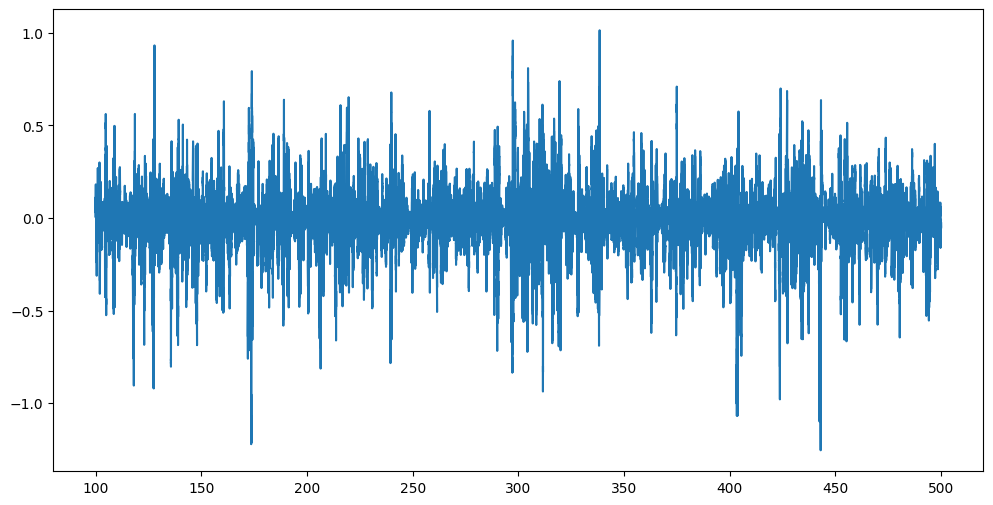

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(t, R)

In [13]:
t_span = (0, 500) # Time span
dt = 0.001  # Time step
epsilon = 0.01

# Initialize a list to hold DataFrames
dfs = []

# Loop over U values
for U in np.arange(0.05, 0.31, 0.01):
    # Solve the SDE
    t, y = euler_maruyama(t_span, dt, epsilon, U)
    R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2]

    # Find the index corresponding to time t=100
    start_index = int(100 / dt)

    # Slice R array starting from the index of t=100
    R = R[start_index:]
    
    # Create a temporary DataFrame for current U value
    temp_df = pd.DataFrame({'U': np.repeat(U, len(R)), 'R': R})

    # Append the temporary DataFrame to the list
    dfs.append(temp_df)

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

# Save the DataFrame to a CSV file
# df.to_csv('./data/train_data_eachU.csv', index=False)

In [23]:
# Calculate mean and variance of R for each U
mean_df = df.groupby('U')['R'].mean().reset_index(name='Mean_R')
variance_df = df.groupby('U')['R'].var().reset_index(name='R_Variance')

# Merge the mean and variance DataFrames
stats_df = pd.merge(mean_df, variance_df, on='U')

# Save the DataFrame to a CSV file
stats_df.to_csv('./data/train_data_Rdistrib.csv', index=False)

In [15]:
# Calculate autocorrelation functions for U and R
R_autocorr = autocorrelation_fft(R)

#Replace df['R'] with Rolling mean of R with window size 1000
# df['R'] = df['R'].rolling(1000).mean()

# Add autocorrelation of U to the DataFrame
# df['R_autocorr'] = R_autocorr

# moving average of U (window size 100)
df['mov_avg'] = df['R'].rolling(100).mean()

# moving average of U (window size 1000)
df['mov_avg2'] = df['R'].rolling(1000).mean()


df = df.dropna() #drop the rows with NaN values

df.to_csv('./data/train_data_R_avg.csv', index=False) #save the dataframe as a csv file


In [4]:
data = pd.read_csv('./data/train_data_Rdistrib.csv')

In [5]:
data1 = pd.read_csv('./data/train_data_histogram_longtime_210000_coursegrained.csv')
U1 = data1['U']

In [6]:
U = data['U']
Mean_R = data['Mean_R']
Var_R = data['R_Variance']

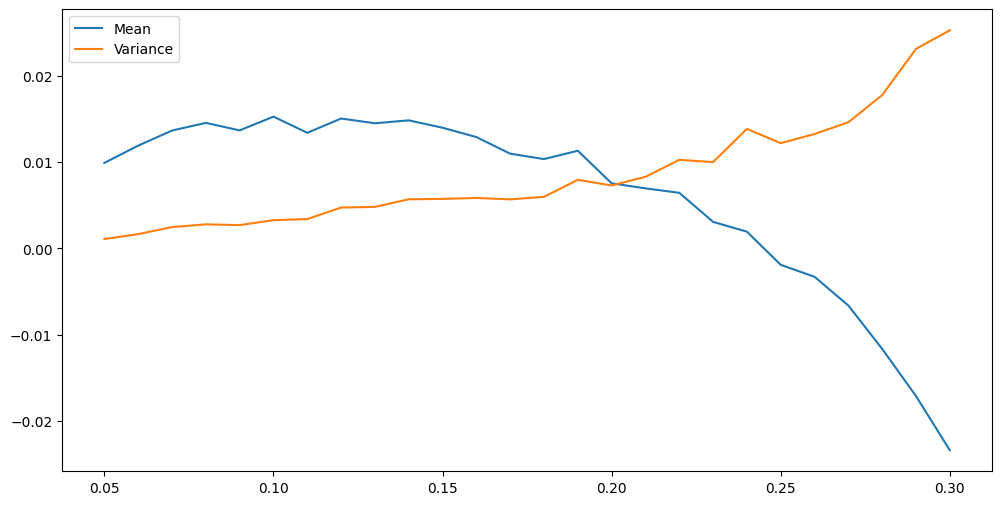

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(U, Mean_R, label='Mean')
plt.plot(U, Var_R, label='Variance')
plt.legend()
plt.show()

In [8]:
# mean of U
mean_U = np.mean(U, axis=0)
print(mean_U)

0.175


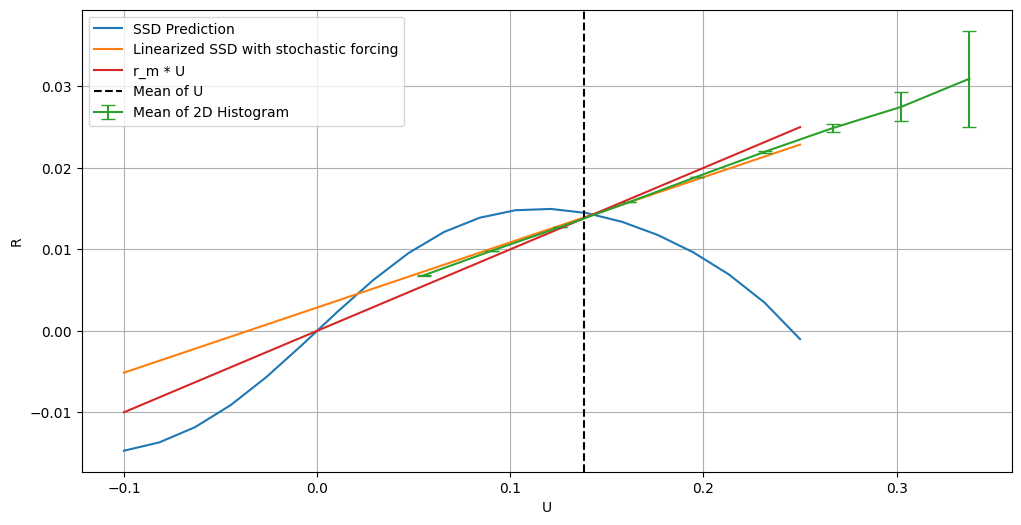

In [17]:
with open("./variables_2D_hist.pickle", "rb") as f:
    u_centers, R_mean_in_bins, std_R_given_U, R_sem_in_bins = pickle.load(f)
with open("./variables.pickle", "rb") as f:
    R_space, U_space = pickle.load(f)

with open("variables_eigen.pickle", "rb") as f:
    R_final, U_final, U_noise, C_noise = pickle.load(f)

y = R_final + 0.08*(U_space-U_final)

# plt.plot(test_input[sorted_indices], predictions[sorted_indices], label='Neural Network Prediction')
plt.figure(figsize=(12, 6))
# plt.plot(U, Mean_R, label='Mean of R with U constant')
plt.plot(U_space, R_space, label='SSD Prediction')
plt.plot(U_space, y, label='Linearized SSD with stochastic forcing')
# plt.plot(u_centers, R_mean_in_bins ,'-', label='Mean of 2D Histogram')
plt.errorbar(u_centers, R_mean_in_bins, yerr=R_sem_in_bins, fmt='-', capsize=5, label='Mean of 2D Histogram')
plt.plot(U_space, r_m*U_space, label='r_m * U')
plt.axvline(x=0.1384, color='k', linestyle='--', label='Mean of U')
plt.grid(True)
#plt.ylim(0, 0.02)
plt.xlabel('U')
plt.ylabel('R')
plt.legend()
plt.show()

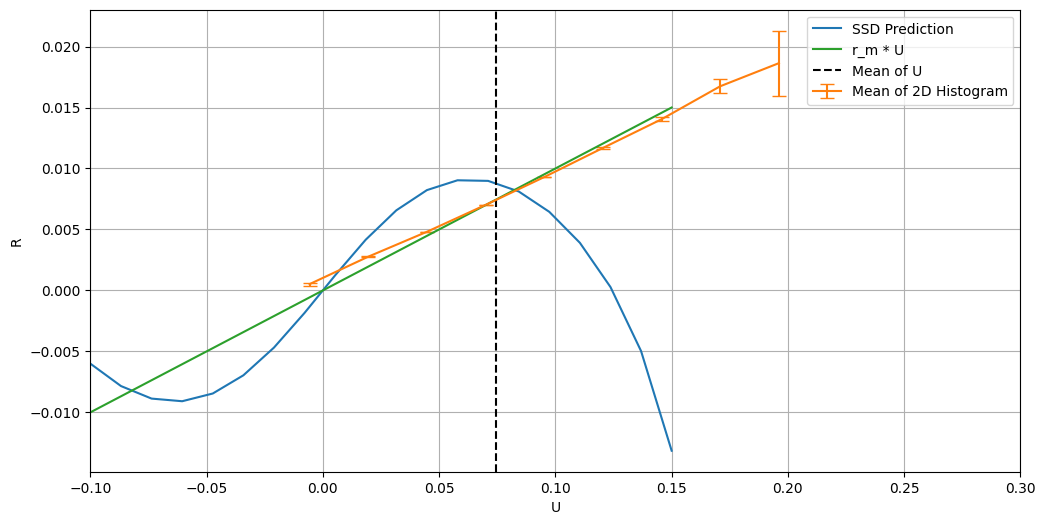

In [9]:
with open("./variables_2D_hist_2.pickle", "rb") as f:
    u_centers, R_mean_in_bins, std_R_given_U, R_sem_in_bins = pickle.load(f)

with open("./variables_2.pickle", "rb") as f:
    R_space, U_space = pickle.load(f)

# plt.plot(test_input[sorted_indices], predictions[sorted_indices], label='Neural Network Prediction')
plt.figure(figsize=(12, 6))
# plt.plot(U, Mean_R, label='Mean of R with U constant')
plt.plot(U_space, R_space, label='SSD Prediction')
# plt.plot(u_centers, R_mean_in_bins ,'-', label='Mean of 2D Histogram')
plt.errorbar(u_centers, R_mean_in_bins, yerr=R_sem_in_bins, fmt='-', capsize=5, label='Mean of 2D Histogram')
plt.plot(U_space, r_m*U_space, label='r_m * U')
plt.axvline(x=0.0746, color='k', linestyle='--', label='Mean of U')
plt.grid(True)
#plt.ylim(0, 0.02)
plt.xlim(-0.1, 0.3)
plt.xlabel('U')
plt.ylabel('R')
plt.legend()
plt.show()

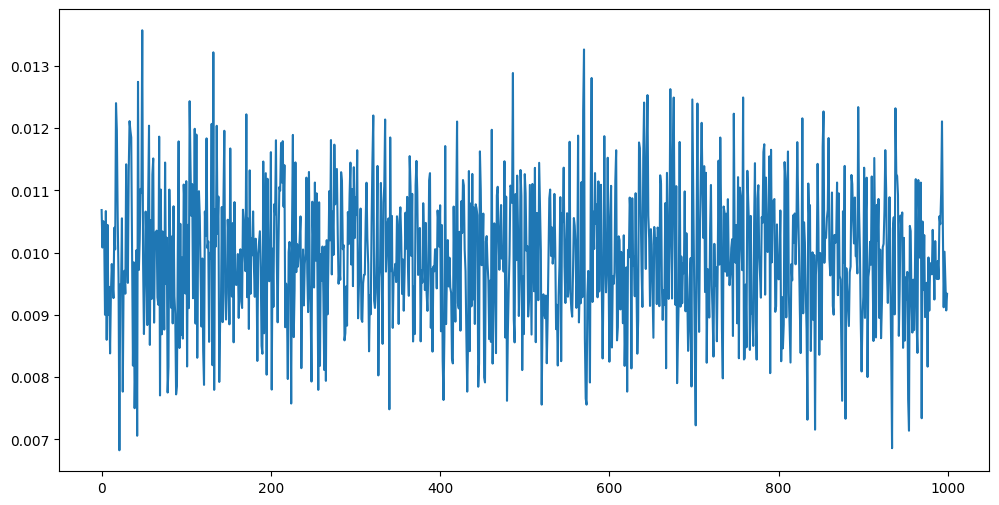

In [23]:
# random distribution with 1000 points of R with mean_R and variance_R
R = np.random.normal(Mean_R[0], Var_R[0], 1000)

plt.figure(figsize=(12, 6))
# plt.hist(R, bins=100)
plt.plot(R)


In [35]:
data1 = pd.read_csv('./data/train_data_eachU.csv')

In [60]:
U_005 = data1[data1['U'] == 0.05]
U_010 = data1[data1['U'] == 0.10]
U_015 = data1[data1['U'] == 0.15]


In [67]:
#find the skewness of R for each U using scipy.stats.skew
skew_005 = scipy.stats.skew(U_005['R'])
skew_010 = scipy.stats.skew(U_010['R'])
skew_015 = scipy.stats.skew(U_015['R'])


print(skew_005)
print(skew_010)
print(skew_015)

1.2019787125730836
1.211821953935651
1.112963745411779


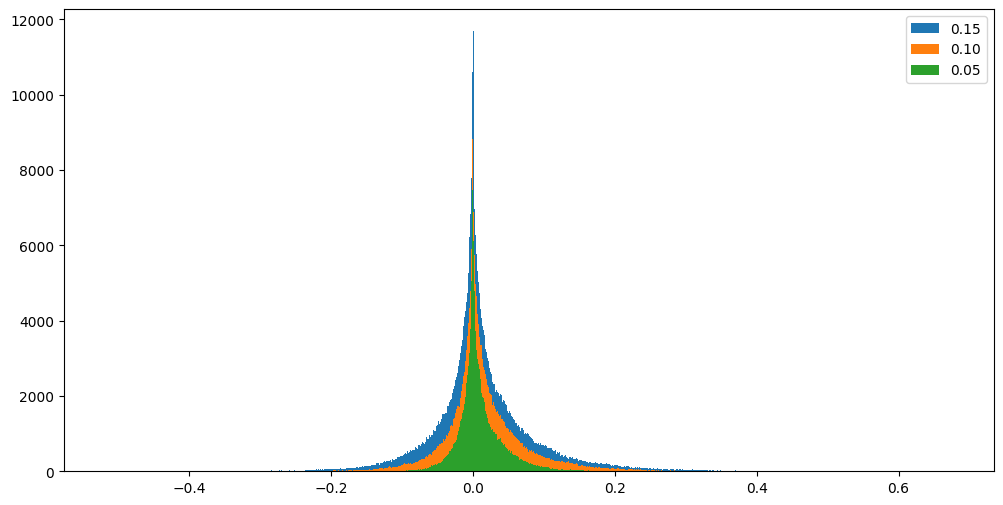

In [62]:
plt.figure(figsize=(12, 6))
#plot the first column of U_005
plt.hist(U_015.iloc[:, 1], bins=1000, label = '0.15')
plt.hist(U_010.iloc[:, 1], bins=1000, label = '0.10')
plt.hist(U_005.iloc[:, 1], bins=1000, label = '0.05')
plt.legend()
plt.show()

In [ ]:
# Calculate autocorrelation functions for U and R
U_autocorr = autocorrelation_fft(U)

In [6]:
#Replace df['R'] with Rolling mean of R with window size 1000
df['R'] = df['R'].rolling(1000).mean()

# Add autocorrelation of U to the DataFrame
df['U_autocorr'] = U_autocorr

# moving average of U (window size 100)
df['mov_avg'] = df['U'].rolling(100).mean()

# moving average of U (window size 1000)
df['mov_avg2'] = df['U'].rolling(1000).mean()

# moving average of U (window size 10000)
df['mov_avg3'] = df['U'].rolling(10000).mean()

df = df.dropna() #drop the rows with NaN values

# df.to_csv('./data/train_data_autocorr.csv', index=False) #save the dataframe as a csv file


In [7]:
#From the df dataframe, subsample the rows with a step size of 8500 and save it as a new dataframe and then save it as a csv file
df2 = df.iloc[::8500, :]
df2.to_csv('./data/train_data_subsampled_autocorr1.csv', index=False)

In [25]:
#display nan values
print(df.isnull().sum())

U                  0
R                  0
std               99
std2             999
var               99
var2             999
mov_avg           99
mov_avg2         999
mov_avg3        9999
exp_mov_avg        0
exp_mov_avg2       0
detrend1          99
detrend2         999
detrend3        9999
dtype: int64


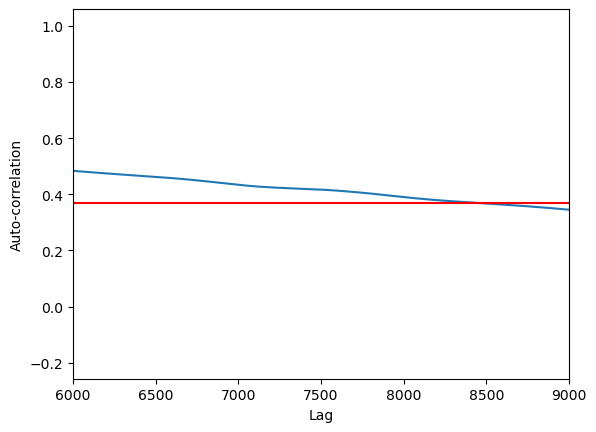

In [8]:
# Calculate U'
U_prime = U - np.mean(U)

# Compute the correlation with FFT
U_prime_fft = np.fft.fft(U_prime)
U_prime_fft = np.abs(U_prime_fft) ** 2
U_prime_fft = np.fft.ifft(U_prime_fft)
U_prime_fft = np.real(U_prime_fft)

# Extract the positive lags
U_prime_fft = U_prime_fft[:len(U_prime_fft) // 2]

# Normalize the auto-correlation function
U_prime_fft = U_prime_fft / U_prime_fft[0]

# Plot the auto-correlation function
plt.plot(U_prime_fft)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
#plt.xlim(6000,9000)
plt.axhline(y=1/np.e, color='r', linestyle='-')
plt.show()